In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

*Load Data*

In [ ]:
file_path = "flight_data.csv"
df = pd.read_csv(file_path)
print("Data shape: ", df.shape)
df.head()

*Inspect data*

In [ ]:
print(df.columns)
print(df.info())
print(df.describe())

*Data Cleaning*

In [ ]:
df = df.drop("sensors", axis=1)
df = df.drop_duplicates()
print(df.shape)

*Convert UNIX time to datetime*

In [ ]:
for col in ["time_position","last_contact"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], unit='s', errors="coerce")
print(df.head())

*Handle missing values*

In [ ]:
print(df.isna().sum())
df = df.dropna(subset=["longitude", "latitude"])

**EXPLORATORY ANALYSIS**

*Set Graph Styles*

In [113]:
sns.set_style("darkgrid")  # adds seaborn style to charts, eg. grid
plt.style.use("dark_background")  # inverts colors to dark theme
sns.set_palette("colorblind")
# sns.reset_defaults()

*Flights per country*

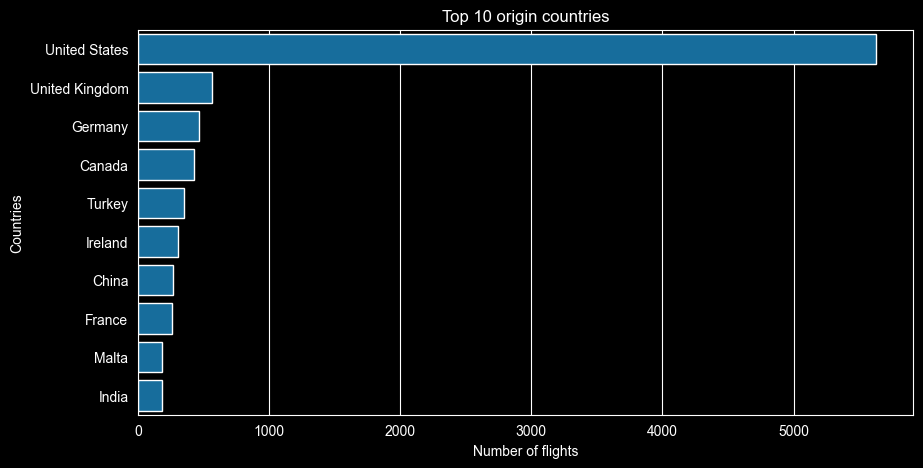

In [114]:
if "origin_country" in df.columns:
    top_country_count = (df["origin_country"].value_counts().head(10))
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_country_count.values, y=top_country_count.index)
    plt.title("Top 10 origin countries")
    plt.xlabel("Number of flights")
    plt.ylabel("Countries")
    plt.show()    